In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Get predictions for a subset of data.

```bash
SPLICEVO_DIR=/home/elek/projects/splicevo/
OUT_DIR=/home/elek/projects/splicing/results
CHECKPOINT_DIR=subset
python ${SPLICEVO_DIR}/scripts/splicevo_predict.py \
--checkpoint ${OUT_DIR}/models/${CHECKPOINT_DIR}/best_model.pt \
--test-data ${OUT_DIR}/data_processing/processed_data_test.npz \
--normalization-stats ${OUT_DIR}/models/${CHECKPOINT_DIR}/normalization_stats.json \
--output ${OUT_DIR}/predictions/test_predictions_subset.npz > ${OUT_DIR}/predictions/test_predictions_subset.log 2>&1 &
```

Load subset test data for which predictions were made.

In [2]:
# Load test data
test_path = "/home/elek/projects/splicing/results/data_processing_filtered/processed_data_test.npz"
data = np.load(test_path)

test_sequences = data['sequences']
test_labels = data['labels']

test_sse = data['usage_sse']
test_alpha = data['usage_alpha']
test_beta = data['usage_beta']

test_sse = np.nan_to_num(test_sse, nan=0.0)
test_alpha = np.nan_to_num(test_alpha, nan=0.0)
test_beta = np.nan_to_num(test_beta, nan=0.0)

print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test usage shape: {test_sse.shape}")
print(f"Test alpha shape: {test_alpha.shape}")
print(f"Test beta shape: {test_beta.shape}")

Test sequences shape: (79156, 10000, 4)
Test labels shape: (79156, 1000)
Test usage shape: (79156, 1000, 62)
Test alpha shape: (79156, 1000, 62)
Test beta shape: (79156, 1000, 62)


Check where are the splice sites in the first few sequences

In [3]:
# Splice sites in the first few test sequences
for i in range(5):
    print(f"Splice sites in sequence {i}:")
    print(f"  donors (1)    {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  acceptors (2) {np.where(test_labels[i] == 2)[0].tolist()}")

Splice sites in sequence 0:
  donors (1)    [0]
  acceptors (2) []
Splice sites in sequence 1:
  donors (1)    []
  acceptors (2) [973]
Splice sites in sequence 2:
  donors (1)    [13]
  acceptors (2) []
Splice sites in sequence 3:
  donors (1)    []
  acceptors (2) [0]
Splice sites in sequence 4:
  donors (1)    [463]
  acceptors (2) [586]


Count how many splice sites per test sequence are there.

In [ ]:
num_splice_sites = {}
for i in range(test_labels.shape[0]):
    num_donors = apply(lambda x: np.sum(x == 1), axis=1)(test_labels[i])
    num_acceptors = apply(lambda x: np.sum(x == 2), axis=1)(test_labels[i])
    num_splice_sites['donors'].append(num_donors)
    num_splice_sites['acceptors'].append(num_acceptors)

num_splice_sites

Inspect distribution of usage values at splice sites

In [5]:
cls_dict = {0: 'non-splice site', 1: 'donor', 2: 'acceptor'}

for cls in [1, 2]: # 1: donor, 2: acceptor
    cls_idxs_0 = np.where(test_labels == cls)[0]
    cls_idxs_1 = np.where(test_labels == cls)[1]
    print(f"Number of {cls_dict[cls]} sites: {len(cls_idxs_0)}")
    for tis_idx in range(5): # 5 tissues
        sse_values = test_sse[cls_idxs_0, cls_idxs_1, tis_idx]
        alpha_values = test_alpha[cls_idxs_0, cls_idxs_1, tis_idx]
        beta_values = test_beta[cls_idxs_0, cls_idxs_1, tis_idx]
        print(f"{tis_idx}")
        print(f"{np.sum(sse_values > 0)} sites have mapped usage values ({np.sum(sse_values > 0) / len(sse_values) * 100:.2f}%)")
        print(f"    SSE - mean: {np.mean(sse_values):.4f}, std: {np.std(sse_values):.4f}")
        print(f"    Alpha - mean: {np.mean(alpha_values):.4f}, std: {np.std(alpha_values):.4f}")
        print(f"    Beta - mean: {np.mean(beta_values):.4f}, std: {np.std(beta_values):.4f}")

Number of donor sites: 82795
0
35828 sites have mapped usage values (43.27%)
    SSE - mean: 0.3838, std: 0.4517
    Alpha - mean: 24.8730, std: 116.9533
    Beta - mean: 2.6549, std: 15.7584
1
35793 sites have mapped usage values (43.23%)
    SSE - mean: 0.3742, std: 0.4470
    Alpha - mean: 36.5627, std: 185.6205
    Beta - mean: 5.3453, std: 40.2145
2
30918 sites have mapped usage values (37.34%)
    SSE - mean: 0.3348, std: 0.4438
    Alpha - mean: 15.8029, std: 81.0770
    Beta - mean: 1.8052, std: 14.5304
3
30550 sites have mapped usage values (36.90%)
    SSE - mean: 0.3380, std: 0.4508
    Alpha - mean: 19.3287, std: 86.4877
    Beta - mean: 1.6414, std: 12.5872
4
33901 sites have mapped usage values (40.95%)
    SSE - mean: 0.3631, std: 0.4514
    Alpha - mean: 33.1092, std: 158.8725
    Beta - mean: 3.8974, std: 33.6795
Number of acceptor sites: 79180
0
35859 sites have mapped usage values (45.29%)
    SSE - mean: 0.3964, std: 0.4500
    Alpha - mean: 25.4690, std: 117.5625
 

Load predictions (this takes ~10 mins...)

In [ ]:
# Load the model predictions from a file
pred_path = "/home/elek/projects/splicing/results/predictions/test_predictions_subset_filtered.npz"
pred = np.load(pred_path)

# Keys in the loaded data
print(f"Available keys: {list(pred.keys())}")
for key in pred.keys():
    print(f"{key}: {pred[key].shape}")

pred_preds = pred['splice_predictions']
pred_probs = pred['splice_probs']

Available keys: ['splice_predictions', 'splice_probs', 'usage_alpha', 'usage_beta', 'usage_sse', 'labels_true', 'usage_alpha_true', 'usage_beta_true', 'usage_sse_true']
splice_predictions: (79156, 1000)
splice_probs: (79156, 1000, 3)
usage_alpha: (79156, 1000, 62)
usage_beta: (79156, 1000, 62)


Inspect predictions vs true labels for the first few sequences.

In [4]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(test_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_preds[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(test_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_preds[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       [0]
  predicted    [1, 3, 21, 35, 69, 74, 77, 92, 122, 167, 193, 196, 208, 212, 223, 229, 246, 254, 320, 324, 347, 373, 390, 400, 408, 420, 437, 470, 485, 500, 514, 515, 523, 528, 541, 545, 574, 585, 597, 603, 609, 615, 624, 651, 675, 693, 711, 717, 721, 729, 760, 763, 770, 802, 831, 832, 845, 861, 868, 881, 887, 896, 909, 913, 920, 929, 949, 987, 988, 991, 992, 996]
(2) Acceptor splice sites in sequence 0:
  actual    []
  predicted [6, 32, 34, 42, 64, 73, 85, 99, 109, 115, 121, 129, 132, 139, 177, 180, 181, 187, 191, 192, 195, 203, 228, 232, 233, 238, 286, 294, 296, 297, 298, 307, 308, 310, 323, 332, 341, 360, 363, 365, 370, 372, 389, 396, 399, 412, 417, 436, 448, 449, 451, 463, 466, 469, 481, 505, 511, 527, 561, 578, 595, 608, 622, 642, 643, 650, 660, 665, 666, 669, 680, 715, 718, 732, 744, 750, 751, 777, 801, 805, 806, 807, 808, 809, 810, 812, 822, 830, 837, 842, 863, 866, 867, 879, 880, 886, 898, 904, 928, 966, 969, 970, 975, 9

In [6]:
for i, j in [(0, 0), (0, 1), (1, 21), (2, 13)]:
    print(f"Sequence {i}, position {j}:\n  true label: {test_labels[i,j]}\n  pred label: {pred_preds[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 0
  porbs:[0.4989597  0.23828614 0.2627541 ]
Sequence 0, position 1:
  true label: 0
  pred label: 1
  porbs:[0.33909017 0.5215835  0.1393263 ]
Sequence 1, position 21:
  true label: 0
  pred label: 1
  porbs:[0.18840827 0.5999837  0.21160805]
Sequence 2, position 13:
  true label: 1
  pred label: 0
  porbs:[0.4639237  0.37501976 0.1610565 ]


Calculate PR-AUC, the area under the precision-recall curve.

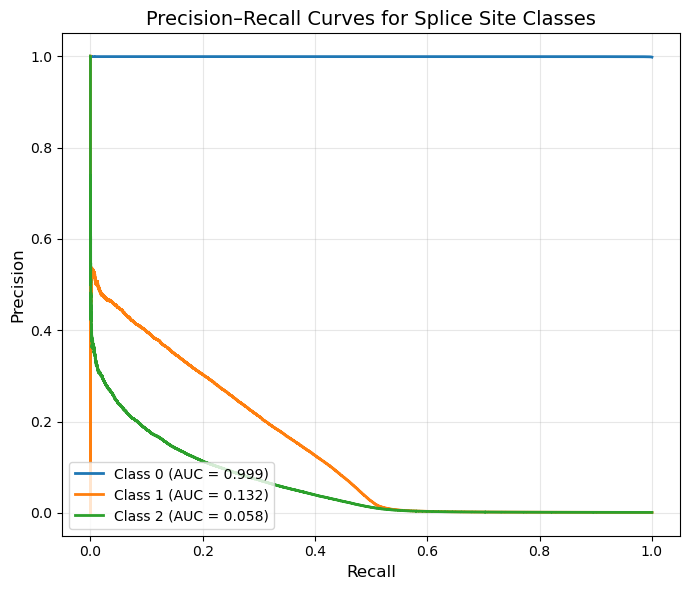

PR-AUC for class 0: 0.9990
PR-AUC for class 1: 0.1317
PR-AUC for class 2: 0.0583


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(7, 6))

for class_idx in range(3):
    # Binary labels for the current class
    y_true = (pred['labels_true'] == class_idx).astype(int).reshape(-1)
    # Predicted probabilities for that class
    y_scores = pred['splice_probs'][:, :, class_idx].reshape(-1)

    # Compute PR curve and area
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    # Plot
    plt.plot(
        recall, precision,
        label=f"Class {class_idx} (AUC = {pr_auc:.3f})",
        linewidth=2
    )

# Plot formatting
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("plots/pr_curves_splicevo_subset.png", dpi=300)
plt.show()

# Print PR-AUC values
for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for class {c}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [8]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    y_true = (pred['labels_true'] == class_idx).astype(int)
    y_true = y_true.reshape(-1)
    y_scores = pred['splice_probs'][:,:,class_idx]
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.9984
Top-k accuracy for class 1: 0.2540
Top-k accuracy for class 2: 0.1454
